## Android Tap and Sensor Fusion

### Import Libraries

In [116]:
import pandas as pd
import numpy as np
from collections import OrderedDict as od
from numpy import mean, var
from scipy.stats import skew, kurtosis
import json
import matplotlib.pyplot as plt
import glob
import os
import ast
import seaborn as sns, numpy as np
%matplotlib inline
import matplotlib.dates as dates
import statsmodels.api as sm
import os, sys, inspect
sys.path.insert(0,'../Scripts/madgwickahrs.py')
from madgwickahrs import *
from quaternion import *

##### Sensor Data Parser

In [2]:
ls ../Data/SensorInfo/

201711091951  201711092033  201711161638  201711182141


In [3]:
def parseSensorData(filename):
    x=pd.read_csv(filename)
    x.columns=x.columns.map(lambda x:str(x).strip())
    sensorNameDict=dict(zip(set(x.sensorName),[str(sensor).strip().partition(' ')[2] for sensor in (set(x.sensorName))]))
    x['sensorName']=x['sensorName'].replace(sensorNameDict)
    data_Accelerometer=x.loc[x.sensorName=="Accelerometer"].reset_index().drop(['index','sensorName'],axis=1)
    data_Gyroscope=x.loc[x.sensorName=="Gyroscope"].reset_index().drop(['index','sensorName'],axis=1)
    data_Magnetometer=x.loc[x.sensorName=="Magnetometer"].reset_index().drop(['index','sensorName'],axis=1)
    acc=data_Accelerometer[['timestamp','lastAccelerometerValues[0]','lastAccelerometerValues[1]','lastAccelerometerValues[2]']].groupby('timestamp').mean()
    gyr=data_Gyroscope[['timestamp','lastGyroscopeValues[0]','lastGyroscopeValues[1]','lastGyroscopeValues[2]']].groupby('timestamp').mean()
    mag=data_Magnetometer[['timestamp','lastMagnetometerValues[0]','lastMagnetometerValues[1]','lastMagnetometerValues[2]']].groupby('timestamp').mean()
    return acc,gyr,mag

In [ ]:
from madgwick_py import madgwickahrs, quaternion

##### Tap Data Parser

In [4]:
ls ../Data/TapInfo/

ml16-141402-201711091951-export.json  ml16-141402-201711161638-export.json
ml16-141402-201711092033-export.json  ml16-141402-201711182141-export.json


In [5]:
def parseTapData(filename):
    tapInfo=pd.read_json(filename)
    cols=['eventTime', 'pointerCount', 'source', 'buttonState', 'actionButton', 'id0', 'historySize', 'toolType0', 'flags', 'deviceId', 'downTime', 'action', 'y0', 'x0', 'metaState', 'edgeFlags']
    df=pd.DataFrame(columns=cols)
    for btnID, btn in tapInfo.btnID.iteritems():
        sample=ast.literal_eval(str(btn).replace('u\'','\''))
        for timestamp in sample.keys():
            event=ast.literal_eval(str(sample[timestamp]))
            if type(event) is dict:
                idx = event.keys()[0]
                row=str(event[idx]) 
            else:
                idx=0
                row=str(event[0])
            t=row.replace('MotionEvent ','').replace('[','').replace(']','').replace('=','\':\'').replace(', ','\', \'').replace('\'{ ','{\'').replace(' }\'','\'}')
            dt=ast.literal_eval(t)
            dx=pd.DataFrame.from_records([dt],index=[0])
            if '2' in dx.columns:
                dx=pd.DataFrame.from_records([dx['2'][0]],index=[0]) 
            dx['action']=dx['action'][0][7:]
            dx['id0']=idx
            dx['actionButton']=int(btnID)
            dx['buttonState']=long(timestamp)
            dx['downTime']=long(dx['downTime'])
            dx['eventTime']=long(dx['eventTime'])
            df=pd.concat([df,dx],axis=0)
    df=df.sort('eventTime').reset_index().drop(['index','metaState','deviceId','edgeFlags','flags','historySize','pointerCount','source','toolType0','id0','x0','y0'],axis=1)
    df=df[df['action']=='UP']
    return df

### Load all data

In [6]:
accData=od()
gyrData=od()
magData=od()
tapData=od()

In [7]:
for filename in glob.glob('../Data/SensorInfo/201711*'):
    key=filename.split('/')[-1]
    print(key)
    accData[key],gyrData[key],magData[key]=parseSensorData(filename)

201711092033
201711182141
201711161638
201711091951


In [8]:
for filename in glob.glob('../Data/TapInfo/ml16-141402-201711*'):
    key=filename.split('ml16-141402-')[-1].split('-')[0]
    print(key)
    tapData[key]=parseTapData(filename)

201711091951


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


201711092033
201711182141
201711161638


### Data Integration & Feature Extraction

In [9]:
data=od()

In [175]:
def getData(acc,gyr,mag,row):
        prior=50
        span=30
        win=row['eventTime']-row['downTime']
        a1=acc.query('timestamp>='+str(row['downTime']-prior)+'and timestamp<='+str(row['downTime']+win//2))
        g1=gyr.query('timestamp>='+str(row['downTime']-prior)+'and timestamp<='+str(row['downTime']+win//2))
        m1=mag.query('timestamp>='+str(row['downTime']-prior)+'and timestamp<='+str(row['downTime']+win//2))
        a2=acc.query('timestamp>='+str(row['downTime']+win//2)+'and timestamp<='+str(row['downTime']+span))
        g2=gyr.query('timestamp>='+str(row['downTime']+win//2)+'and timestamp<='+str(row['downTime']+span))
        m2=mag.query('timestamp>='+str(row['downTime']+win//2)+'and timestamp<='+str(row['downTime']+span))

        d=pd.concat([
            pd.DataFrame([row['actionButton']],columns=['target']).T,
            a1.apply(mean).rename(lambda x:x+'_mean_D').T,
            a1.apply(var).rename(lambda x:x+'_var_D'),
            a1.apply(skew).rename(lambda x:x+'_skew_D'),
            a1.apply(kurtosis).rename(lambda x:x+'_kurtosis_D'),
            g1.apply(mean).rename(lambda x:x+'_mean_D'),
            g1.apply(var).rename(lambda x:x+'_var_D'),
            g1.apply(skew).rename(lambda x:x+'_skew_D'),
            g1.apply(kurtosis).rename(lambda x:x+'_kurtosis_D'),
            m1.apply(mean).rename(lambda x:x+'_mean_D'),
            m1.apply(var).rename(lambda x:x+'_var_D'),
            m1.apply(skew).rename(lambda x:x+'_skew_D'),
            m1.apply(kurtosis).rename(lambda x:x+'_kurtosis_D'),
            a2.apply(mean).rename(lambda x:x+'_mean_U').T,
            a2.apply(var).rename(lambda x:x+'_var_U'),
            a2.apply(skew).rename(lambda x:x+'_skew_U'),
            a2.apply(kurtosis).rename(lambda x:x+'_kurtosis_U'),
            g2.apply(mean).rename(lambda x:x+'_mean_U'),
            g2.apply(var).rename(lambda x:x+'_var_U'),
            g2.apply(skew).rename(lambda x:x+'_skew_U'),
            g2.apply(kurtosis).rename(lambda x:x+'_kurtosis_U'),
            m2.apply(mean).rename(lambda x:x+'_mean_U'),
            m2.apply(var).rename(lambda x:x+'_var_U'),
            m2.apply(skew).rename(lambda x:x+'_skew_U'),
            m2.apply(kurtosis).rename(lambda x:x+'_kurtosis_U')
        ]
            ,axis=0).T
        return d

In [176]:
def fusion(acc, gyr, mag, tap):
    df=pd.DataFrame()
    for idx,row in tap.iterrows():
        d=getData(acc,gyr,mag,row)
        df=df.append([d],ignore_index=True)
    return df

In [179]:
for key in tapData.keys():
        print key
        data[key]=fusion(accData[key], gyrData[key], magData[key], tapData[key])
        data[key].to_csv('../Data/Features/'+str(key)+'_features.csv')

201711091951
201711092033
201711182141
201711161638


In [180]:
data

NameError: name 'estimator0' is not defined

In [170]:
for key in data.keys():

In [159]:
for key in accData.keys():
    key='201711182141'
    a=accData[key]
    g=gyrData[key]
    m=magData[key]
    t=tapData[key]
    print t.head()

    sensors=pd.concat([a,g,m],axis=1)
    sensors=pd.DataFrame(sensors,index=range(sensors.index[0],sensors.index[-1])).fillna(method='bfill')
    target=pd.DataFrame()
    old=999
    for idx,row in sensors.iterrows():
        act=-1
        q=t.query('eventTime>='+str(idx)+' and downTime<='+str(idx))
        if len(q)>0:
            act=q.index[0]
        sensors.loc[idx,'target']=act
    break

  action  actionButton  buttonState    downTime   eventTime
1     UP           0.0   15316443.0  15316358.0  15316442.0
3     UP           0.0   15317178.0  15317093.0  15317177.0
5     UP           0.0   15317867.0  15317799.0  15317863.0
7     UP           0.0   15318677.0  15318594.0  15318674.0
9     UP           0.0   15319545.0  15319461.0  15319543.0


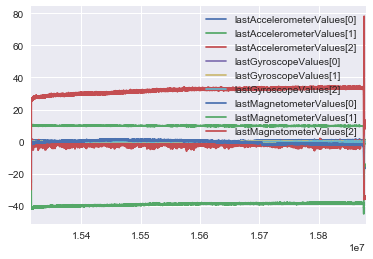

In [126]:
sensors.plot()

In [127]:
plt.show()

In [ ]:
ax = sns.plt(,fit=norm, kde=False)

In [13]:
def plotSensor(data):
    for key in data.keys():
        data[key].plot(title=key)
    plt.show()

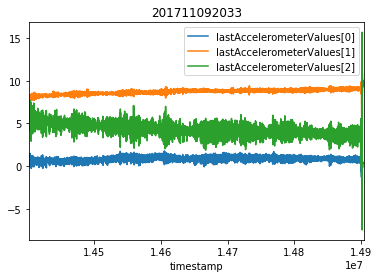

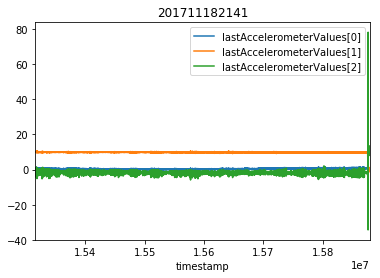

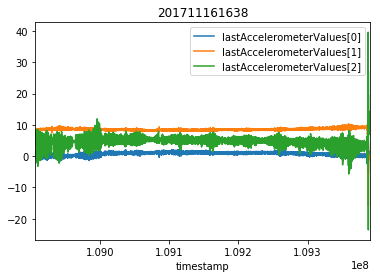

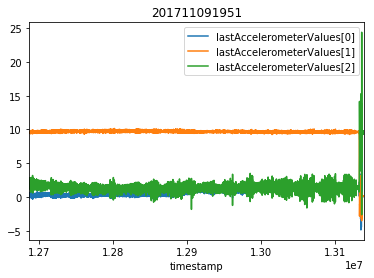

In [14]:
plotSensor(accData)

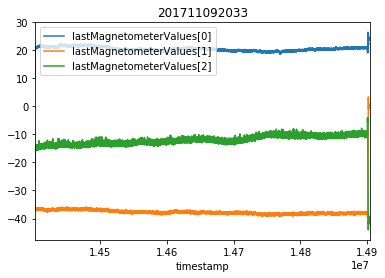

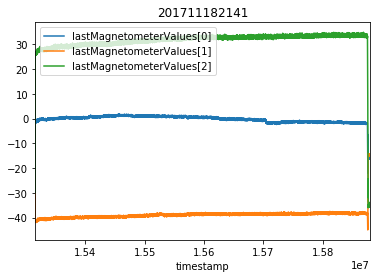

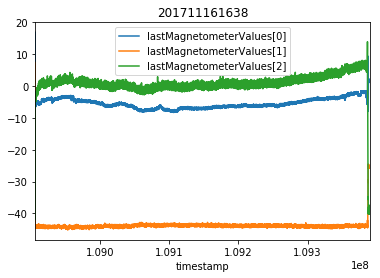

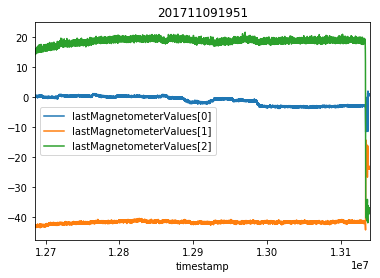

In [15]:
plotSensor(magData)

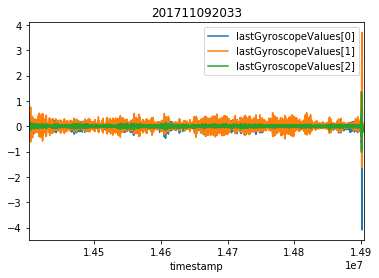

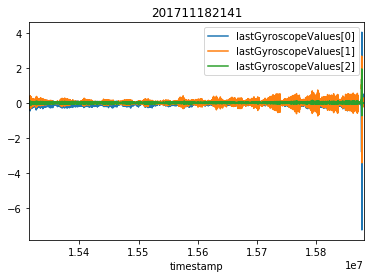

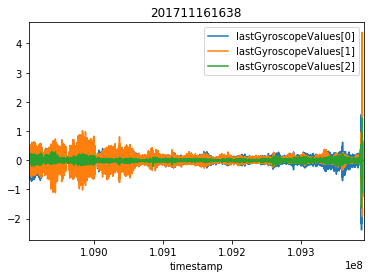

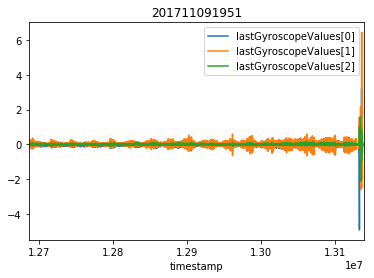

In [16]:
plotSensor(gyrData)

201711091951


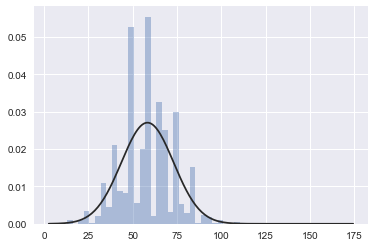

201711092033


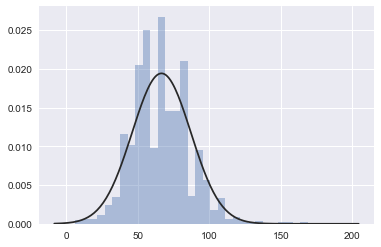

201711182141


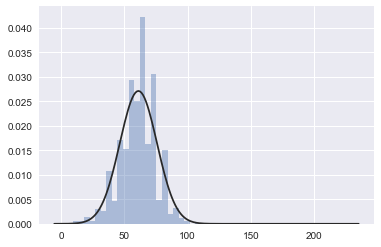

201711161638


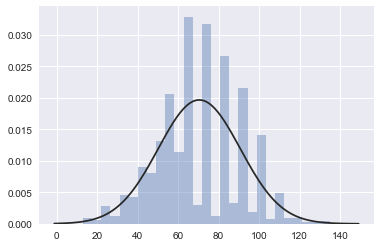

In [24]:
for key in tapData.keys():
    print(key)
    plotTapIntervalDist(tapData[key])
    plt.show()

In [18]:
from scipy.stats import norm
def plotTapIntervalDist(t):
    ax = sns.distplot((t.eventTime-t.downTime),fit=norm, kde=False)

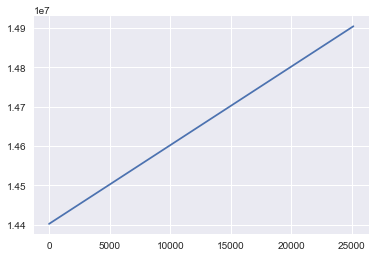

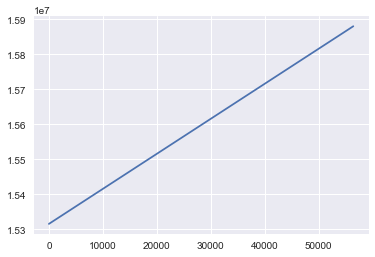

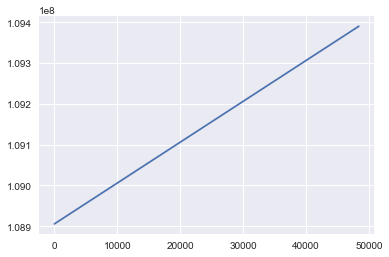

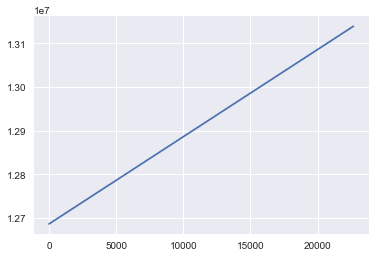

In [33]:

for key in magData.keys():
    plt.plot(magData[key].index)
    plt.show()


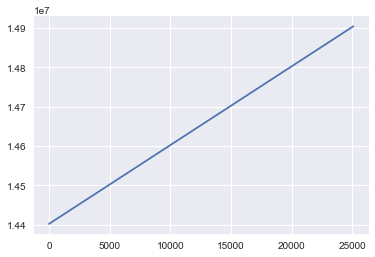

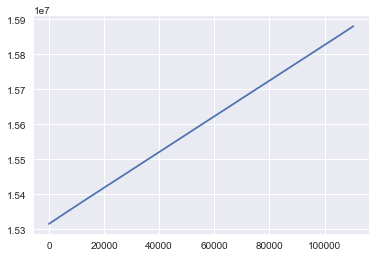

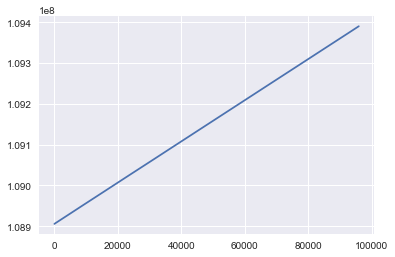

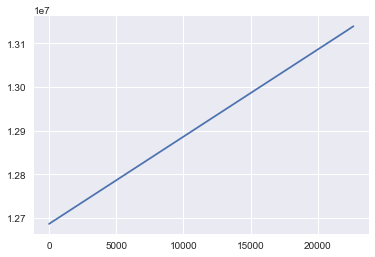

In [32]:
for key in gyrData.keys():
    plt.plot(gyrData[key].index)
    plt.show()

In [34]:
for key in accData.keys():
    print(accData[key].index)
    #plt.show()

Int64Index([14402109, 14402110, 14402219, 14402220, 14402221, 14402299,
            14402300, 14402327, 14402336, 14402356,
            ...
            14904135, 14904155, 14904175, 14904197, 14904215, 14904237,
            14904255, 14904275, 14904295, 14904315],
           dtype='int64', name=u'timestamp', length=25092)
Int64Index([15315114, 15315115, 15315116, 15315199, 15315200, 15315201,
            15315202, 15315277, 15315278, 15315279,
            ...
            15880084, 15880089, 15880096, 15880099, 15880105, 15880109,
            15880115, 15880119, 15880125, 15880129],
           dtype='int64', name=u'timestamp', length=111709)
Int64Index([108905671, 108905672, 108905673, 108905674, 108905675, 108905676,
            108905682, 108905821, 108905822, 108905823,
            ...
            109390355, 109390360, 109390364, 109390369, 109390374, 109390380,
            109390385, 109390392, 109390395, 109390400],
           dtype='int64', name=u'timestamp', length=96260)
Int64In

# fin.

In [ ]:
a = a.set_index(pd.DatetimeIndex(df['b']))

In [141]:
a.index.astype(int)

Int64Index([108905671, 108905672, 108905673, 108905674, 108905675, 108905676,
            108905682, 108905821, 108905822, 108905823,
            ...
            109390355, 109390360, 109390364, 109390369, 109390374, 109390380,
            109390385, 109390392, 109390395, 109390400],
           dtype='int64', name=u'timestamp', length=96260)

UnboundLocalError: local variable 'x' referenced before assignment

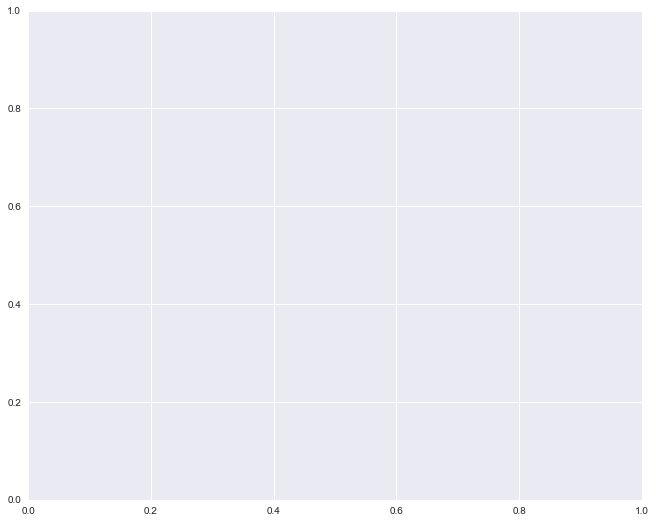

In [139]:
sns.tsplot(a)

In [78]:
for key in accData.keys():
    key='201711182141'
    a=accData[key]
    g=gyrData[key]
    m=magData[key]
    print key
    break
    
    

201711182141


In [79]:
a.index[1:]-a.index[:-1]

Int64Index([ 1,  1, 83,  1,  1,  1, 75,  1,  1,  5,
            ...
             5,  5,  7,  3,  6,  4,  6,  4,  6,  4],
           dtype='int64', name=u'timestamp', length=111708)

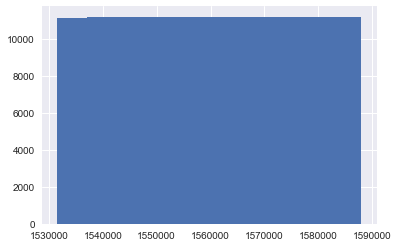

In [80]:
plt.hist(a.index/10)
plt.show()

In [81]:
len(m)

56410

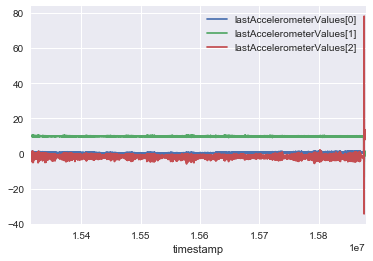

In [84]:
a.plot()

In [98]:
sensors=pd.concat([a,g,m],axis=1)
sensors=pd.DataFrame(sensors,index=range(sensors.index[0],sensors.index[-1])).fillna(method='bfill')

In [124]:
new_data = MadgwickAHRS() 
old_data = MadgwickAHRS() 
for idx,row in sensors.iterrows():
    
    acc = np.array( [row['lastAccelerometerValues[0]'], row['lastAccelerometerValues[0]'], row['lastAccelerometerValues[0]']])
    gyr = np.array( [row['lastGyroscopeValues[0]'], row['lastGyroscopeValues[0]'], row['lastGyroscopeValues[0]']])
    mag = np.array( [row['lastMagnetometerValues[0]'], row['lastMagnetometerValues[0]'], row['lastMagnetometerValues[0]']])
    print acc
    gyr_rad = gyr * (np.pi/180)
    new_data.update(gyr_rad,acc,mag)
    if old_data!=new_data:
        print(new_data.quaternion.q)
        old_data=new_data

[ 0.70596313  0.70596313  0.70596313]
[ 1.  0.  0.  0.]
[ 0.69447936  0.69447936  0.69447936]
[ 0.64435196  0.64435196  0.64435196]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.6353836]
[ 0.6353836  0.6353836  0.63

[ 0.5001831  0.5001831  0.5001831]
[ 0.5001831  0.5001831  0.5001831]
[ 0.5001831  0.5001831  0.5001831]
[ 0.50737  0.50737  0.50737]
[ 0.50737  0.50737  0.50737]
[ 0.50737  0.50737  0.50737]
[ 0.50737  0.50737  0.50737]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.55522156  0.55522156  0.55522156]
[ 0.55522156  0.55522156  0.55522156]
[ 0.55522156  0.55522156  0.55522156]
[ 0.55522156  0.55522156  0.55522156]
[ 0.5576172  0.5576172  0.5576172]
[ 0.5576172  0.5576172  0.5576172]
[ 0.5576172  0.5576172  0.5576172]
[ 0.5576172  0.5576172  0.5576172]
[ 0.5576172  0.5576172  0.5576172]
[ 0.5767517  0.5767517  0.5767517]
[ 0.5767517  0.5767517  0.5767517]
[ 0.5767517  0.5767517  0.5767517]
[ 0.5767517  0.5767517  0.5767517]
[ 0.5767517  0.5767517  0.5767517]
[ 0.5887146  0.5887146  0.5887146]
[ 0.5887146  0.5887146  0.588714

[ 0.7897186  0.7897186  0.7897186]
[ 0.7633972  0.7633972  0.7633972]
[ 0.7633972  0.7633972  0.7633972]
[ 0.7633972  0.7633972  0.7633972]
[ 0.7633972  0.7633972  0.7633972]
[ 0.7633972  0.7633972  0.7633972]
[ 0.7251129  0.7251129  0.7251129]
[ 0.7251129  0.7251129  0.7251129]
[ 0.7251129  0.7251129  0.7251129]
[ 0.7251129  0.7251129  0.7251129]
[ 0.7251129  0.7251129  0.7251129]
[ 0.71554565  0.71554565  0.71554565]
[ 0.71554565  0.71554565  0.71554565]
[ 0.71554565  0.71554565  0.71554565]
[ 0.71554565  0.71554565  0.71554565]
[ 0.71554565  0.71554565  0.71554565]
[ 0.7035675  0.7035675  0.7035675]
[ 0.7035675  0.7035675  0.7035675]
[ 0.7035675  0.7035675  0.7035675]
[ 0.7035675  0.7035675  0.7035675]
[ 0.7035675  0.7035675  0.7035675]
[ 0.73947144  0.73947144  0.73947144]
[ 0.73947144  0.73947144  0.73947144]
[ 0.73947144  0.73947144  0.73947144]
[ 0.73947144  0.73947144  0.73947144]
[ 0.73947144  0.73947144  0.73947144]
[ 0.7370758  0.7370758  0.7370758]
[ 0.7370758  0.7370758  0

[ 0.7035675  0.7035675  0.7035675]
[ 0.717926  0.717926  0.717926]
[ 0.717926  0.717926  0.717926]
[ 0.717926  0.717926  0.717926]
[ 0.717926  0.717926  0.717926]
[ 0.717926  0.717926  0.717926]
[ 0.76579285  0.76579285  0.76579285]
[ 0.76579285  0.76579285  0.76579285]
[ 0.76579285  0.76579285  0.76579285]
[ 0.76579285  0.76579285  0.76579285]
[ 0.76579285  0.76579285  0.76579285]
[ 0.7490387  0.7490387  0.7490387]
[ 0.7490387  0.7490387  0.7490387]
[ 0.7490387  0.7490387  0.7490387]
[ 0.7490387  0.7490387  0.7490387]
[ 0.7490387  0.7490387  0.7490387]
[ 0.74664307  0.74664307  0.74664307]
[ 0.74664307  0.74664307  0.74664307]
[ 0.74664307  0.74664307  0.74664307]
[ 0.74664307  0.74664307  0.74664307]
[ 0.74664307  0.74664307  0.74664307]
[ 0.7490387  0.7490387  0.7490387]
[ 0.7490387  0.7490387  0.7490387]
[ 0.7490387  0.7490387  0.7490387]
[ 0.7490387  0.7490387  0.7490387]
[ 0.7490387  0.7490387  0.7490387]
[ 0.7514343  0.7514343  0.7514343]
[ 0.7514343  0.7514343  0.7514343]
[ 0.7

[ 0.5265045  0.5265045  0.5265045]
[ 0.5265045  0.5265045  0.5265045]
[ 0.55522156  0.55522156  0.55522156]
[ 0.55522156  0.55522156  0.55522156]
[ 0.55522156  0.55522156  0.55522156]
[ 0.55522156  0.55522156  0.55522156]
[ 0.55522156  0.55522156  0.55522156]
[ 0.5623932  0.5623932  0.5623932]
[ 0.5623932  0.5623932  0.5623932]
[ 0.5623932  0.5623932  0.5623932]
[ 0.5623932  0.5623932  0.5623932]
[ 0.5623932  0.5623932  0.5623932]
[ 0.5504303  0.5504303  0.5504303]
[ 0.5504303  0.5504303  0.5504303]
[ 0.5504303  0.5504303  0.5504303]
[ 0.5504303  0.5504303  0.5504303]
[ 0.5504303  0.5504303  0.5504303]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.4738617  0.4738617  0.4738617]
[ 0.4738617  

[ 0.7298889  0.7298889  0.7298889]
[ 0.73947144  0.73947144  0.73947144]
[ 0.73947144  0.73947144  0.73947144]
[ 0.73947144  0.73947144  0.73947144]
[ 0.73947144  0.73947144  0.73947144]
[ 0.73947144  0.73947144  0.73947144]
[ 0.7346802  0.7346802  0.7346802]
[ 0.7346802  0.7346802  0.7346802]
[ 0.7346802  0.7346802  0.7346802]
[ 0.7346802  0.7346802  0.7346802]
[ 0.7346802  0.7346802  0.7346802]
[ 0.7346802  0.7346802  0.7346802]
[ 0.6605072  0.6605072  0.6605072]
[ 0.6605072  0.6605072  0.6605072]
[ 0.6605072  0.6605072  0.6605072]
[ 0.6605072  0.6605072  0.6605072]
[ 0.60546875  0.60546875  0.60546875]
[ 0.60546875  0.60546875  0.60546875]
[ 0.60546875  0.60546875  0.60546875]
[ 0.60546875  0.60546875  0.60546875]
[ 0.60546875  0.60546875  0.60546875]
[ 0.5623932  0.5623932  0.5623932]
[ 0.5623932  0.5623932  0.5623932]
[ 0.5623932  0.5623932  0.5623932]
[ 0.5623932  0.5623932  0.5623932]
[ 0.5623932  0.5623932  0.5623932]
[ 0.59350586  0.59350586  0.59350586]
[ 0.59350586  0.593505

[ 0.615036  0.615036  0.615036]
[ 0.6126404  0.6126404  0.6126404]
[ 0.6126404  0.6126404  0.6126404]
[ 0.6126404  0.6126404  0.6126404]
[ 0.6126404  0.6126404  0.6126404]
[ 0.6126404  0.6126404  0.6126404]
[ 0.5887146  0.5887146  0.5887146]
[ 0.5887146  0.5887146  0.5887146]
[ 0.5887146  0.5887146  0.5887146]
[ 0.5887146  0.5887146  0.5887146]
[ 0.5887146  0.5887146  0.5887146]
[ 0.54325867  0.54325867  0.54325867]
[ 0.54325867  0.54325867  0.54325867]
[ 0.54325867  0.54325867  0.54325867]
[ 0.54325867  0.54325867  0.54325867]
[ 0.54325867  0.54325867  0.54325867]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.52171326  0.52171326  0.52171326]
[ 0.52171326  0.52171326  0.52171326]
[ 0.52171326  0.52171326  0.52171326]
[ 0.52171326  0.52171326  0.52171326]
[ 0.52171326  0.52171326  0.52171326]
[ 0.51693726  0.51693726  0.51693726]
[ 0.51693726  0.51693726 

[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[-0.28944397 -0.28944397 -0.28944397]
[-0.28944397 -0.28944397 -0.28944397]
[-0.28944397 -0.28944397 -0.28944397]
[-0.28944397 -0.28944397 -0.28944397]
[-0.28944397 -0.28944397 -0.28944397]
[-0.32055664 -0.32055664 -0.32055664]
[-0.32055664 -0.32055664 -0.32055664]
[-0.32055664 -0.32055664 -0.32055664]
[-0.32055664 -0.32055664 -0.32055664]
[-0.32055664 -0.32055664 -0.32055664]
[ 0.00965881  0.00965881  0.00965881]
[ 0.00965881  0.00965881  0.00965881]
[ 0.00965881  0.00965881  0.00965881]
[ 0.00965881  0.00965881  0.00965881]
[ 0.00965881  0.00965881  0.00965881]
[ 0.15083313  0.15083313  0.15083313]
[ 0.15083313  0.15083313  0.15083313]
[ 0.15083313  0.15083313  0.15083313]
[ 0.15083313  0.15083313  0.15083313]
[ 0.15083313  0.15083313  0.15083313]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.301574

[ 0.6269989  0.6269989  0.6269989]
[ 0.5743561  0.5743561  0.5743561]
[ 0.5743561  0.5743561  0.5743561]
[ 0.5743561  0.5743561  0.5743561]
[ 0.5743561  0.5743561  0.5743561]
[ 0.5743561  0.5743561  0.5743561]
[ 0.5456543  0.5456543  0.5456543]
[ 0.5456543  0.5456543  0.5456543]
[ 0.5456543  0.5456543  0.5456543]
[ 0.5456543  0.5456543  0.5456543]
[ 0.5456543  0.5456543  0.5456543]
[ 0.5743561  0.5743561  0.5743561]
[ 0.5743561  0.5743561  0.5743561]
[ 0.5743561  0.5743561  0.5743561]
[ 0.5743561  0.5743561  0.5743561]
[ 0.5743561  0.5743561  0.5743561]
[ 0.56718445  0.56718445  0.56718445]
[ 0.56718445  0.56718445  0.56718445]
[ 0.56718445  0.56718445  0.56718445]
[ 0.56718445  0.56718445  0.56718445]
[ 0.56718445  0.56718445  0.56718445]
[ 0.54086304  0.54086304  0.54086304]
[ 0.54086304  0.54086304  0.54086304]
[ 0.54086304  0.54086304  0.54086304]
[ 0.54086304  0.54086304  0.54086304]
[ 0.54086304  0.54086304  0.54086304]
[ 0.54086304  0.54086304  0.54086304]
[ 0.54086304  0.540863

[ 0.684433  0.684433  0.684433]
[ 0.684433  0.684433  0.684433]
[ 0.684433  0.684433  0.684433]
[ 0.684433  0.684433  0.684433]
[ 0.684433  0.684433  0.684433]
[ 0.684433  0.684433  0.684433]
[ 0.684433  0.684433  0.684433]
[ 0.684433  0.684433  0.684433]
[ 0.684433  0.684433  0.684433]
[ 0.684433  0.684433  0.684433]
[ 0.6605072  0.6605072  0.6605072]
[ 0.65571594  0.65571594  0.65571594]
[ 0.65571594  0.65571594  0.65571594]
[ 0.65571594  0.65571594  0.65571594]
[ 0.65571594  0.65571594  0.65571594]
[ 0.65571594  0.65571594  0.65571594]
[ 0.65571594  0.65571594  0.65571594]
[ 0.65571594  0.65571594  0.65571594]
[ 0.65571594  0.65571594  0.65571594]
[ 0.65571594  0.65571594  0.65571594]
[ 0.69400024  0.69400024  0.69400024]
[ 0.69400024  0.69400024  0.69400024]
[ 0.6748657  0.6748657  0.6748657]
[ 0.6748657  0.6748657  0.6748657]
[ 0.6748657  0.6748657  0.6748657]
[ 0.6748657  0.6748657  0.6748657]
[ 0.6748657  0.6748657  0.6748657]
[ 0.6748657  0.6748657  0.6748657]
[ 0.6748657  0.67

[ 0.50975037  0.50975037  0.50975037]
[ 0.50975037  0.50975037  0.50975037]
[ 0.47146606  0.47146606  0.47146606]
[ 0.47146606  0.47146606  0.47146606]
[ 0.47146606  0.47146606  0.47146606]
[ 0.47146606  0.47146606  0.47146606]
[ 0.47146606  0.47146606  0.47146606]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.47625732  0.47625732  0.47625732]
[ 0.47625732  0.47625732  0.47625732]
[ 0.47625732  0.47625732  0.47625732]
[ 0.47625732  0.47625732  0.47625732]
[ 0.47625732  0.47625732  0.47625732]
[ 0.5312958  0.5312958  0.5312958]
[ 0.5312958  0.5312958  0.5312958]
[ 0.5312958  0.5312958  0.5312958]
[ 0.5312958  0.5312958  0.5312958]
[ 0.5312958  0.5312958  0.5312958]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.

[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.39250183  0.39250183  0.39250183]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896

[ 0.13407898  0.13407898  0.13407898]
[ 0.13407898  0.13407898  0.13407898]
[ 0.13407898  0.13407898  0.13407898]
[ 0.22979736  0.22979736  0.22979736]
[ 0.22979736  0.22979736  0.22979736]
[ 0.22979736  0.22979736  0.22979736]
[ 0.22979736  0.22979736  0.22979736]
[ 0.22979736  0.22979736  0.22979736]
[ 0.22979736  0.22979736  0.22979736]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.3015747  0.3015747]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.48582459  0.48582459  0.48582459]
[ 0.48582459  0.48582459  0.48582459]
[ 0.48582459  0.48582459  0.48582459]
[ 0.48582459  0.48582459  0.48

[ 0.5767517  0.5767517  0.5767517]
[ 0.5241089  0.5241089  0.5241089]
[ 0.5241089  0.5241089  0.5241089]
[ 0.5241089  0.5241089  0.5241089]
[ 0.5241089  0.5241089  0.5241089]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.50975037  0.50975037  0.50975037]
[ 0.50975037  0.50975037  0.50975037]
[ 0.50975037  0.50975037  0.50975037]
[ 0.50975037  0.50975037  0.50975037]
[ 0.50975037  0.50975037  0.50975037]
[ 0.50975037  0.50975037  0.50975037]
[ 0.50975037  0.50975037  0.50975037]
[ 0.50975037  0.50975037  0.50975037]
[ 0.5265045  0.5265045  0.5265045]
[ 0.5265045  0.5265045  0.5265045]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.5384674]
[ 0.5384674  0.5384674  0.53846

[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45710754

[ 0.21304321  0.21304321  0.21304321]
[ 0.21304321  0.21304321  0.21304321]
[ 0.15562439  0.15562439  0.15562439]
[ 0.15562439  0.15562439  0.15562439]
[ 0.15562439  0.15562439  0.15562439]
[ 0.15562439  0.15562439  0.15562439]
[ 0.15562439  0.15562439  0.15562439]
[ 0.15562439  0.15562439  0.15562439]
[ 0.15562439  0.15562439  0.15562439]
[ 0.15562439  0.15562439  0.15562439]
[ 0.15562439  0.15562439  0.15562439]
[ 0.15562439  0.15562439  0.15562439]
[ 0.15562439  0.15562439  0.15562439]
[ 0.15562439  0.15562439  0.15562439]
[ 0.10536194  0.10536194  0.10536194]
[ 0.10775757  0.10775757  0.10775757]
[ 0.10775757  0.10775757  0.10775757]
[ 0.10775757  0.10775757  0.10775757]
[ 0.10775757  0.10775757  0.10775757]
[ 0.10775757  0.10775757  0.10775757]
[ 0.10775757  0.10775757  0.10775757]
[ 0.10775757  0.10775757  0.10775757]
[ 0.11254883  0.11254883  0.11254883]
[ 0.13407898  0.13407898  0.13407898]
[ 0.13407898  0.13407898  0.13407898]
[ 0.13407898  0.13407898  0.13407898]
[ 0.13407898

[ 0.3733673  0.3733673  0.3733673]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.48582458  0.48582458  0.48582458]
[ 0.48582458  0.48582458  0.48582458]
[ 0.48582458  0.48582458  0.48582458]
[ 0.48582458  0.48582458  0.48582458]
[ 0.48582458  0.48582458  0.48582458]
[ 0.49301147  0

[ 0.47865295  0.47865295  0.47865295]
[ 0.51693726  0.51693726  0.51693726]
[ 0.51693726  0.51693726  0.51693726]
[ 0.51693726  0.51693726  0.51693726]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40

[ 0.26808167  0.26808167  0.26808167]
[ 0.26808167  0.26808167  0.26808167]
[ 0.26808167  0.26808167  0.26808167]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.4116516  0.4116516  0.4116516]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.5241089  0.5241089  0.5241089]
[ 0.5241089  0.5241089  0.5241089]
[ 0.5241089  0.5241089  0.5241089]
[ 0.5241089  0.5241089  

[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.3590088  0.3590088  0.3590088]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.32789612  0.32789612  0.32789612]
[ 0.32789612  0.32789612  0

[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.44754028

[ 0.09579468  0.09579468  0.09579468]
[ 0.09579468  0.09579468  0.09579468]
[ 0.09579468  0.09579468  0.09579468]
[ 0.08383179  0.08383179  0.08383179]
[ 0.08383179  0.08383179  0.08383179]
[ 0.0718689  0.0718689  0.0718689]
[ 0.0718689  0.0718689  0.0718689]
[ 0.0718689  0.0718689  0.0718689]
[ 0.0718689  0.0718689  0.0718689]
[ 0.0718689  0.0718689  0.0718689]
[ 0.10058594  0.10058594  0.10058594]
[ 0.10058594  0.10058594  0.10058594]
[ 0.10058594  0.10058594  0.10058594]
[ 0.10058594  0.10058594  0.10058594]
[ 0.10058594  0.10058594  0.10058594]
[ 0.19628906  0.19628906  0.19628906]
[ 0.19628906  0.19628906  0.19628906]
[ 0.19628906  0.19628906  0.19628906]
[ 0.19628906  0.19628906  0.19628906]
[ 0.19628906  0.19628906  0.19628906]
[ 0.23936462  0.23936462  0.23936462]
[ 0.23936462  0.23936462  0.23936462]
[ 0.23936462  0.23936462  0.23936462]
[ 0.23936462  0.23936462  0.23936462]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0

[ 0.41882324  0.41882324  0.41882324]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.36857605  0.36857605  0.36857605]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005 

[ 0.3733673  0.3733673  0.3733673]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.3972931  0.3972931  0.3972931]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.

[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.512146  0.512146  0.512146]
[ 0.512146  0.512146  0.512146]
[ 0.512146  0.512146  0.512146]
[ 0.52890015  0.52890015  0.52890015]
[ 0.52890015  0.52890015  0.52890015]
[ 0.52890015  0.52890015  0.52890015]
[ 0.52890015  0.52890015  0.52890015]
[ 0.52890015  0.52890015  0.52890015]
[ 0.52890015  0.52890015  0.52890015]
[ 0.52890015  0.52890015  0.52890015]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44

[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.392

[ 0.3207245  0.3207245  0.3207245]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.3135376  0.3135376  0.3135376]
[ 0.3135376  0.3135376  0.3135376]
[ 0.3135376  0.3135376  0.3135376]
[ 0.3135376  0.3135376  0.3135376]
[ 0.3135376  0.3135376  0.3135376]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.4212

[ 0.49301147  0.49301147  0.49301147]
[ 0.47865295  0.47865295  0.47865295]
[ 0.47865295  0.47865295  0.47865295]
[ 0.47865295  0.47865295  0.47865295]
[ 0.47865295  0.47865295  0.47865295]
[ 0.47865295  0.47865295  0.47865295]
[ 0.47865295  0.47865295  0.47865295]
[ 0.47865295  0.47865295  0.47865295]
[ 0.47865295  0.47865295  0.47865295]
[ 0.47865295  0.47865295  0.47865295]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  

[ 0.4236145  0.4236145  0.4236145]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.366180

[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.46429443  0.46429443  0.46429443]
[ 0.46429443  0.46429443  0.46429443]
[ 0.46429443  0.46429443  0.46429443]
[ 0.46429443  0.46429443  0.46429443]
[ 0.

[ 0.3087616  0.3087616  0.3087616]
[ 0.3087616  0.3087616  0.3087616]
[ 0.2824402  0.2824402  0.2824402]
[ 0.2824402  0.2824402  0.2824402]
[ 0.2824402  0.2824402  0.2824402]
[ 0.2824402  0.2824402  0.2824402]
[ 0.2824402  0.2824402  0.2824402]
[ 0.29919434  0.29919434  0.29919434]
[ 0.29919434  0.29919434  0.29919434]
[ 0.29919434  0.29919434  0.29919434]
[ 0.29919434  0.29919434  0.29919434]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.390121

[ 0.3781433  0.3781433  0.3781433]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116

[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0

[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.351821

[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.41882324

[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.34225464  0.34225464  0.34225464]
[ 0.34225464  0.34225464  0.34225464]
[ 0.34225464  0.34225464  0.34225464]
[ 0.34225464  0.34225464  0.34225464]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.409

[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.30636597  0.30636597  0.30636597]
[ 0.30636597  0.30636597  0.30636597]
[ 0.30636597  0.30636597  0.30636597]
[ 0.30636597  0.30636597  0.30636597]
[ 0.30636597  0.30636597  0.30636597]
[ 0.30636597  0.30636597  0.30636597]
[ 0.30636597  0.30636597  0.30636597]
[ 0.30636597  0.30636597  0.30636597]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0

[ 0.7681732  0.7681732  0.7681732]
[ 0.8950043  0.8950043  0.8950043]
[ 0.8950043  0.8950043  0.8950043]
[ 0.8950043  0.8950043  0.8950043]
[ 0.8950043  0.8950043  0.8950043]
[ 0.85910034  0.85910034  0.85910034]
[ 0.85910034  0.85910034  0.85910034]
[ 0.85910034  0.85910034  0.85910034]
[ 0.85910034  0.85910034  0.85910034]
[ 0.85910034  0.85910034  0.85910034]
[ 0.85910034  0.85910034  0.85910034]
[ 0.71554565  0.71554565  0.71554565]
[ 0.71554565  0.71554565  0.71554565]
[ 0.71554565  0.71554565  0.71554565]
[ 0.71554565  0.71554565  0.71554565]
[ 0.71554565  0.71554565  0.71554565]
[ 0.54086304  0.54086304  0.54086304]
[ 0.54086304  0.54086304  0.54086304]
[ 0.54086304  0.54086304  0.54086304]
[ 0.54086304  0.54086304  0.54086304]
[ 0.54086304  0.54086304  0.54086304]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.23457336  0.23457336  0.23457336]
[ 0.23457336  0.23457336  0.23457336]
[

[ 0.32789612  0.32789612  0.32789612]
[ 0.32789612  0.32789612  0.32789612]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.33268738  0.33268738  0

[ 0.06469727  0.06469727  0.06469727]
[ 0.06469727  0.06469727  0.06469727]
[ 0.06469727  0.06469727  0.06469727]
[ 0.06469727  0.06469727  0.06469727]
[ 0.06468964  0.06468964  0.06468964]
[ 0.06468964  0.06468964  0.06468964]
[ 0.06468964  0.06468964  0.06468964]
[ 0.06468964  0.06468964  0.06468964]
[ 0.06468964  0.06468964  0.06468964]
[ 0.06468964  0.06468964  0.06468964]
[ 0.06468964  0.06468964  0.06468964]
[ 0.06468964  0.06468964  0.06468964]
[ 0.06468964  0.06468964  0.06468964]
[ 0.06468964  0.06468964  0.06468964]
[ 0.06468964  0.06468964  0.06468964]
[ 0.06468964  0.06468964  0.06468964]
[ 0.06468964  0.06468964  0.06468964]
[ 0.12930298  0.12930298  0.12930298]
[ 0.12930298  0.12930298  0.12930298]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469

[ 0.24893188  0.24893188  0.24893188]
[ 0.26808167  0.26808167  0.26808167]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.2824402  0.2824402  0.2824402]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.3590088  0.3590088  0.3590088]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43

[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.4882202  0.4882202  0.4882202]
[ 0.5528259  0.5528259  0.5528259]
[ 0.5528259  0.5528259  0.5528259]
[ 0.5528259  0.5528259  0.5528259]
[ 0.5528259  0.5528259  0.5528259]
[ 0.5528259  0.5528259  0.5528259]
[ 0.5528259  0.5528259  0.5528259]
[ 0.5528259  0.5528259  0.5528259]
[ 0.6078644  0.6078644  0.6078644]
[ 0.6078644  0.6078644  0.6078644]
[ 0.6078644  0.6078644  0.6078644]
[ 0.6078644  0.6078644  0.6078644]
[ 0.6078644  0.6078644  0.6078644]
[ 0.6078644  0.6078644  0.6078644]
[ 0.6078644  0.6078644  0.6078644]
[ 0.6078644  0.6078644  0.6078644]
[ 0.6078644  0.6078644  0.6078644]
[ 0.6078644  0.6078644  0.6078644]
[ 0.6078644  0.6078644  0.6078644]
[ 0.6078644  0.6078644  0.6078644]
[ 0.6078644  0.6078644  0.6078644]

[ 0.3972931  0.3972931  0.3972931]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.45233154  0.45233154  0.45233154]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.44754028  0

[-0.06092834 -0.06092834 -0.06092834]
[-0.07170105 -0.07170105 -0.07170105]
[-0.07170105 -0.07170105 -0.07170105]
[-0.07170105 -0.07170105 -0.07170105]
[-0.02622986 -0.02622986 -0.02622986]
[-0.02622986 -0.02622986 -0.02622986]
[-0.02622986 -0.02622986 -0.02622986]
[-0.02622986 -0.02622986 -0.02622986]
[ 0.02879333  0.02879333  0.02879333]
[ 0.02879333  0.02879333  0.02879333]
[ 0.02879333  0.02879333  0.02879333]
[ 0.02879333  0.02879333  0.02879333]
[ 0.02879333  0.02879333  0.02879333]
[ 0.02879333  0.02879333  0.02879333]
[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.232193  0.232193  0.232193]
[ 0.232193  0.232193  0.232193]
[ 0.232193  0.232193  0.232193]
[ 0.232193  0.232193  0.232193]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316

[ 0.41882324  0.41882324  0.41882324]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.3972931  0.3972931  0.3972931]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.

[ 0.20826721  0.20826721  0.20826721]
[ 0.20826721  0.20826721  0.20826721]
[ 0.20826721  0.20826721  0.20826721]
[ 0.2752533  0.2752533  0.2752533]
[ 0.2752533  0.2752533  0.2752533]
[ 0.2752533  0.2752533  0.2752533]
[ 0.2752533  0.2752533  0.2752533]
[ 0.2752533  0.2752533  0.2752533]
[ 0.2752533  0.2752533  0.2752533]
[ 0.2752533  0.2752533  0.2752533]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.54086304  0.54086304  0.54086304]
[ 0.54086304  0.54086304  0.54086304]
[ 0.54086304  0.540863

[ 0.3733673  0.3733673  0.3733673]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38293457  0.38293457  0.38293457]
[ 0.38293457  0.38293457  0.38293457]
[ 0.38293457  0.38293457  0.38293457]
[ 0.38293457  0.38293457  0.38293457]
[ 0.38293457  0.38293457  0.38293457]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.34225464  0.34225464  0.34225464]
[ 0.34225464  0.34225464  0.34225464]
[ 0.34225464  0.34225464  0.34225464]
[ 0.34225464  0.34225464  0.34225464]
[ 0.34225464  0.34225464  0.34225464]
[ 0.34225464  0.34225464  0.34225464]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.2967987  0.2967987  0.2967987]
[ 0.2967987  0.296

[ 0.71554565  0.71554565  0.71554565]
[ 0.71554565  0.71554565  0.71554565]
[ 0.71554565  0.71554565  0.71554565]
[ 0.5623932  0.5623932  0.5623932]
[ 0.5623932  0.5623932  0.5623932]
[ 0.5623932  0.5623932  0.5623932]
[ 0.5623932  0.5623932  0.5623932]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.15800476  0.15800476  0.15800476]
[ 0.15800476  0.15800476  0.15800476]
[ 0.15800476  0.15800476  0.15800476]
[ 0.15800476  0.15800476  0.15800476]
[ 0.15800476  0.15800476  0.15800476]
[ 0.10058594  0.10058594  0.10058594]
[ 0.10058594  0.10058594  0.10058594]
[ 0.10058594  0.10058594  0.10058594]
[ 0.10058594  0.10058594  0.10058594]
[ 0.10058594  0.10058594

[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.28961182  0.28961182  0.28961182]
[ 0.29919434  0.29919434  0.29919434]
[ 0.29919434  0.29919434  0.29919434]
[ 0.29919434  0.29919434  0.299194

[ 0.861496  0.861496  0.861496]
[ 0.861496  0.861496  0.861496]
[ 0.861496  0.861496  0.861496]
[ 0.72750854  0.72750854  0.72750854]
[ 0.72750854  0.72750854  0.72750854]
[ 0.72750854  0.72750854  0.72750854]
[ 0.72750854  0.72750854  0.72750854]
[ 0.72750854  0.72750854  0.72750854]
[ 0.72750854  0.72750854  0.72750854]
[ 0.5647888  0.5647888  0.5647888]
[ 0.5647888  0.5647888  0.5647888]
[ 0.5647888  0.5647888  0.5647888]
[ 0.5647888  0.5647888  0.5647888]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.1867218  0.1867218  0.1867218]
[ 0.1867218  0.1867218  0.1867218]
[ 0.1867218  0.1867218  0.1867218]
[ 0.1867218  0.1867218  0.1867218]
[ 0.1867218  0.1

[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.4499359  0.4499359  0.4499359]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5

[ 0.21064758  0.21064758  0.21064758]
[ 0.21064758  0.21064758  0.21064758]
[ 0.21064758  0.21064758  0.21064758]
[ 0.21064758  0.21064758  0.21064758]
[ 0.21064758  0.21064758  0.21064758]
[ 0.21064758  0.21064758  0.21064758]
[ 0.21064758  0.21064758  0.21064758]
[ 0.21064758  0.21064758  0.21064758]
[ 0.16996765  0.16996765  0.16996765]
[ 0.16996765  0.16996765  0.16996765]
[ 0.16996765  0.16996765  0.16996765]
[ 0.16758728  0.16758728  0.16758728]
[ 0.16758728  0.16758728  0.16758728]
[ 0.16758728  0.16758728  0.16758728]
[ 0.16758728  0.16758728  0.16758728]
[ 0.16758728  0.16758728  0.16758728]
[ 0.2202301  0.2202301  0.2202301]
[ 0.2202301  0.2202301  0.2202301]
[ 0.2202301  0.2202301  0.2202301]
[ 0.2202301  0.2202301  0.2202301]
[ 0.2202301  0.2202301  0.2202301]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0

[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.40686035  0.40686035  0.40686035]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[

[ 0.54325867  0.54325867  0.54325867]
[ 0.54325867  0.54325867  0.54325867]
[ 0.6652832  0.6652832  0.6652832]
[ 0.6652832  0.6652832  0.6652832]
[ 0.6652832  0.6652832  0.6652832]
[ 0.6652832  0.6652832  0.6652832]
[ 0.7610016  0.7610016  0.7610016]
[ 0.7610016  0.7610016  0.7610016]
[ 0.7610016  0.7610016  0.7610016]
[ 0.7610016  0.7610016  0.7610016]
[ 0.7610016  0.7610016  0.7610016]
[ 0.7610016  0.7610016  0.7610016]
[ 0.7897186  0.7897186  0.7897186]
[ 0.7897186  0.7897186  0.7897186]
[ 0.7897186  0.7897186  0.7897186]
[ 0.7897186  0.7897186  0.7897186]
[ 0.7035675  0.7035675  0.7035675]
[ 0.7035675  0.7035675  0.7035675]
[ 0.7035675  0.7035675  0.7035675]
[ 0.7035675  0.7035675  0.7035675]
[ 0.7035675  0.7035675  0.7035675]
[ 0.7035675  0.7035675  0.7035675]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.36140442  0.36140442  0.36140442]
[ 0.3614044

[ 0.42840576  0.42840576  0.42840576]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.3135376 

[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.45233154  0.45233154  0.45233154]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.37576294  0.37576294  0.37576294]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.39489746  0.39489746  0.39489746]
[ 0.

[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.41644287  0.41644287  0.41644287]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.46669006  0.46669006  0.46669006]
[ 0.46669006  0.46669006  0.46669006]
[ 0.46669006  0.46669006  0.46669006]
[ 0.46669006  0.46669006  0.46669006]
[ 0.46669006  0.46669006  0.46669006]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45

[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37

[ 0.33029175  0.33029175  0.33029175]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176

[ 0.14126587  0.14126587  0.14126587]
[ 0.14126587  0.14126587  0.14126587]
[ 0.14126587  0.14126587  0.14126587]
[ 0.14126587  0.14126587  0.14126587]
[ 0.2250061  0.2250061  0.2250061]
[ 0.2250061  0.2250061  0.2250061]
[ 0.2250061  0.2250061  0.2250061]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.56718445  0.56718445  0.56718445]
[ 0.56718445  0.56718445  0.56718445]
[ 0.56718445  0.56718445  0.56718445]
[ 0.56718445  0.56718445  0.56718445]
[ 0.56718445  0.56718445  0.56718445]
[ 0.650

[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45

[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.13168335  0.13168335  0.13168335]
[ 0.31115723  0.31115723  0.31115723]
[ 0.38772583  0.38772583  0.38772583]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.6485443  0.6485443  0.6485443]
[ 0.6485443  0.6485443  0.6485443]
[ 0.6485443  0.6485443  0.6485443]
[ 0.6485443  0.6485443  0.6485443]
[ 0.6485443  0.6485443  0.6485443]
[ 0.6485443  0.6485443  0.6485443]
[ 0.77056885  0.77056885  0.77056885]
[ 0.77056885  0.77056885  0.77056885]
[ 0.77056885  0.77056885  0.77056885]
[ 0.77056885  0.77056885  0.77056885]
[ 0.94525146  0.94525146  0.94

[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.43797302  0.43797302  0.43797302]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887

[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.39968872  0.39968872  0.39968872]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.03598022  0.03598022  0.03598022]
[ 0.03598022  0.03598022  0.03598022]
[ 0.03598022  0.03598022  0

[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0

[ 0.9380646  0.9380646  0.9380646]
[ 0.9380646  0.9380646  0.9380646]
[ 0.9380646  0.9380646  0.9380646]
[ 0.9380646  0.9380646  0.9380646]
[ 1.0648956  1.0648956  1.0648956]
[ 1.0648956  1.0648956  1.0648956]
[ 1.0648956  1.0648956  1.0648956]
[ 1.0648956  1.0648956  1.0648956]
[ 1.0648956  1.0648956  1.0648956]
[ 0.95961  0.95961  0.95961]
[ 0.95961  0.95961  0.95961]
[ 0.95961  0.95961  0.95961]
[ 0.95961  0.95961  0.95961]
[ 0.95961  0.95961  0.95961]
[ 0.7944946  0.7944946  0.7944946]
[ 0.7944946  0.7944946  0.7944946]
[ 0.7944946  0.7944946  0.7944946]
[ 0.7944946  0.7944946  0.7944946]
[ 0.68203735  0.68203735  0.68203735]
[ 0.68203735  0.68203735  0.68203735]
[ 0.68203735  0.68203735  0.68203735]
[ 0.68203735  0.68203735  0.68203735]
[ 0.68203735  0.68203735  0.68203735]
[ 0.68203735  0.68203735  0.68203735]
[ 0.55522156  0.55522156  0.55522156]
[ 0.55522156  0.55522156  0.55522156]
[ 0.55522156  0.55522156  0.55522156]
[ 0.55522156  0.55522156  0.55522156]
[ 0.55522156  0.5552

[ 0.47146606  0.47146606  0.47146606]
[ 0.47146606  0.47146606  0.47146606]
[ 0.47146606  0.47146606  0.47146606]
[ 0.47146606  0.47146606  0.47146606]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0

[ 0.08143616  0.08143616  0.08143616]
[ 0.09101868  0.09101868  0.09101868]
[ 0.09101868  0.09101868  0.09101868]
[ 0.09101868  0.09101868  0.09101868]
[ 0.09101868  0.09101868  0.09101868]
[ 0.09101868  0.09101868  0.09101868]
[ 0.09101868  0.09101868  0.09101868]
[ 0.09101868  0.09101868  0.09101868]
[ 0.09101868  0.09101868  0.09101868]
[ 0.09101868  0.09101868  0.09101868]
[ 0.17236328  0.17236328  0.17236328]
[ 0.17236328  0.17236328  0.17236328]
[ 0.17236328  0.17236328  0.17236328]
[ 0.17236328  0.17236328  0.17236328]
[ 0.2202301  0.2202301  0.2202301]
[ 0.2202301  0.2202301  0.2202301]
[ 0.2202301  0.2202301  0.2202301]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.2632904  0.2632904  0.2632904]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.

[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.4738617  0.4738617  0.4738617]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380

[ 0.13647461  0.13647461  0.13647461]
[ 0.13647461  0.13647461  0.13647461]
[ 0.13647461  0.13647461  0.13647461]
[ 0.13647461  0.13647461  0.13647461]
[ 0.13647461  0.13647461  0.13647461]
[ 0.15322876  0.15322876  0.15322876]
[ 0.15322876  0.15322876  0.15322876]
[ 0.15322876  0.15322876  0.15322876]
[ 0.15322876  0.15322876  0.15322876]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.19868469  0.19868469  0.19868469]
[ 0.236969  0.236969  0.236969]
[ 0.236969  0.236969  0.236969]
[ 0.28482819  0.28482819

[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.36857605  0.36857605  0.36857605]
[ 0.35063934  0.35063934  0.35063934]
[ 0.35063934  0.35063934  0.35063934]
[ 0.35063934  0.35063934  0.35063934]
[ 0.35063934  0.35063934  0.35063934]
[ 0.35063934  0.35063934  0.35063934]
[ 0.35063934  0.35063934  0.35063934]
[ 0.35063934  0.35063934  0.35063934]
[ 0.35063934  0.35063934  0.35063934]
[ 0.35063934  0.35063934  0.35063934]
[ 0.35063934  0.35063934  0.35063934]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.33268738  0.332687

[ 0.4463501  0.4463501  0.4463501]
[ 0.4463501  0.4463501  0.4463501]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.03477478  0.03477478  0.03477478]
[ 0.03477478  0.03477478  0.03477478]
[ 0.03477478  0.03477478  0.03477478]
[ 0.03477478  0.03477478  0.03477478]
[ 0.03477478  0.03477478  0.03477478]
[ 0.03477478  0.03477478  0.03477478]
[ 0.03477478  0.03477478  0.03477478]
[ 0.03477478  0.03477478  0.03477478]
[ 0.03477478  0.03477478  0.03477478]
[ 0.03477478  0.03477478  0.03477478]
[ 0.03477478  0.03477478  0.03477478]
[ 0.10058594  0.10058594  0.10058594]
[ 0.10058594  0.10

[ 0.2824402  0.2824402  0.2824402]
[ 0.2824402  0.2824402  0.2824402]
[ 0.2824402  0.2824402  0.2824402]
[ 0.2824402  0.2824402  0.2824402]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.3087616  0.3087616  0.3087616]
[ 0.3087616  0.3087616  0.3087616]
[ 0.3087616  0.3087616  0.3087616]
[ 0.3087616  0.3087616  0.3087616]
[ 0.3087616  0.3087616  0.3087616]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.373367

[ 0.5360718  0.5360718  0.5360718]
[ 0.5360718  0.5360718  0.5360718]
[ 0.5360718  0.5360718  0.5360718]
[ 0.5360718  0.5360718  0.5360718]
[ 0.5360718  0.5360718  0.5360718]
[ 0.5360718  0.5360718  0.5360718]
[ 0.5360718  0.5360718  0.5360718]
[ 0.5360718  0.5360718  0.5360718]
[ 0.5360718  0.5360718  0.5360718]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.48342896  0.48342896  0.48342896]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[

[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.3972931  0.3972931  0.3972931]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0

[ 0.49539185  0.49539185  0.49539185]
[ 0.49539185  0.49539185  0.49539185]
[ 0.49539185  0.49539185  0.49539185]
[ 0.49539185  0.49539185  0.49539185]
[ 0.49539185  0.49539185  0.49539185]
[ 0.49539185  0.49539185  0.49539185]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.5336914  0.5336914  0.5336914]
[ 0.512146  0.512146  0.512146]
[ 0.512146  0.512146  0.512146]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.50257874  0.50257874  0.50257874]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.440368

[ 0.21304321  0.21304321  0.21304321]
[ 0.21304321  0.21304321  0.21304321]
[ 0.21304321  0.21304321  0.21304321]
[ 0.03118896  0.03118896  0.03118896]
[ 0.03118896  0.03118896  0.03118896]
[ 0.03118896  0.03118896  0.03118896]
[ 0.03118896  0.03118896  0.03118896]
[ 0.03118896  0.03118896  0.03118896]
[ 0.03118896  0.03118896  0.03118896]
[ 0.03118896  0.03118896  0.03118896]
[ 0.03118896  0.03118896  0.03118896]
[ 0.03118896  0.03118896  0.03118896]
[ 0.03118896  0.03118896  0.03118896]
[ 0.10298157  0.10298157  0.10298157]
[ 0.10298157  0.10298157  0.10298157]
[ 0.16996765  0.16996765  0.16996765]
[ 0.16996765  0.16996765  0.16996765]
[ 0.16996765  0.16996765  0.16996765]
[ 0.16996765  0.16996765  0.16996765]
[ 0.20347595  0.20347595  0.20347595]
[ 0.20347595  0.20347595  0.20347595]
[ 0.20347595  0.20347595  0.20347595]
[ 0.20347595  0.20347595  0.20347595]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035

[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.46429443  0.46429443  0.46429443]
[ 0.46429443  0.46429443  0.46429443]
[ 0.46429443  0.46429443  0.46429443]
[ 0.46429443  0.46429443  0.46429443]
[ 0.46429443  0.46429443  0.46429443]
[ 0.46429443  0.46429443  0.46429443]
[ 0.46429443  0.46429443  0.46429443]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.47625732  0.47625732  0.47625732]
[ 0.47625732  0.47625732  0.47625732]
[ 0.47625732  0.47625732  0.47625732]
[ 0.47625732  0.47625732  0.47625732]
[ 0.47625732  0.47625732  0.47625732]
[ 0.47625732  0.47625732  0.47625732]
[ 0.47625732  0.47625732  0.47625732]
[ 0.47625732  0.47625732  0.47625732]
[ 0.47625732  0.47625732  0.47625732]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576

[ 0.34225464  0.34225464  0.34225464]
[ 0.34225464  0.34225464  0.34225464]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.335083  0.335083  0.335083]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.35661316  0.35661316  0.35661316]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40

[ 0.6963959  0.6963959  0.6963959]
[ 0.6963959  0.6963959  0.6963959]
[ 0.6963959  0.6963959  0.6963959]
[ 0.6963959  0.6963959  0.6963959]
[ 0.6963959  0.6963959  0.6963959]
[ 0.6963959  0.6963959  0.6963959]
[ 0.7035675  0.7035675  0.7035675]
[ 0.7035675  0.7035675  0.7035675]
[ 0.6581116  0.6581116  0.6581116]
[ 0.6581116  0.6581116  0.6581116]
[ 0.6581116  0.6581116  0.6581116]
[ 0.6581116  0.6581116  0.6581116]
[ 0.6581116  0.6581116  0.6581116]
[ 0.6581116  0.6581116  0.6581116]
[ 0.6581116  0.6581116  0.6581116]
[ 0.59350586  0.59350586  0.59350586]
[ 0.59350586  0.59350586  0.59350586]
[ 0.59350586  0.59350586  0.59350586]
[ 0.5456543  0.5456543  0.5456543]
[ 0.5456543  0.5456543  0.5456543]
[ 0.5456543  0.5456543  0.5456543]
[ 0.5456543  0.5456543  0.5456543]
[ 0.5456543  0.5456543  0.5456543]
[ 0.5456543  0.5456543  0.5456543]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.4953918

[ 0.2752533  0.2752533  0.2752533]
[ 0.2752533  0.2752533  0.2752533]
[ 0.2752533  0.2752533  0.2752533]
[ 0.2752533  0.2752533  0.2752533]
[ 0.2752533  0.2752533  0.2752533]
[ 0.2752533  0.2752533  0.2752533]
[ 0.2752533  0.2752533  0.2752533]
[ 0.28483582  0.28483582  0.28483582]
[ 0.28483582  0.28483582  0.28483582]
[ 0.28483582  0.28483582  0.28483582]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.292007

[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.26808167  0.26808167  0.26808167]
[ 0.26808167  0.26808167  0.26808167]
[ 0.26808167  0.26808167  0.26808167]
[ 0.26808167  0.26808167  0.26808167]
[ 0.2250061  0.2250061  0.2250061]
[ 0.2250061  0.2250061  0.2250061]
[ 0.2250061  0.2250061  0.2250061]
[ 0.2250061  0.2250061  0.2250061]
[ 0.2250061  0.2250061  0.2250061]
[ 0.2250061  0.2250061  0.2250061]
[ 0.2250061  0.2250061  0.2250061]
[ 0.2250061  0.2250061  0.2250061]
[ 0.16519165  0.16519165  0.16519165]
[ 0.16519165  0.16519165  0.16519165]
[ 0.16519165  0.16519165  0.16519165]
[ 0.12690735  0.12690735  0.12690735]
[ 0.12690735  0.12690735  0.12690735]
[ 0.12690735  0.12690735  0.12690735]
[ 0.12690735  0.

[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27764893  0.27764893  0.27764893]
[ 0.27287292  0.27287292  0.27287292]
[ 0.27287292  0.27287292  0.27287292]
[ 0.27287292  0.27287292  0.27287292]
[ 0.27287292  0.27287292  0.27287292]
[ 0.27287292  0.27287292  0.27287292]
[ 0.2824402  0.2824402  0.2824402]
[ 0.2824402  0.2824402  0.2824402]
[ 0.2824402  0.2824402  0.2824402]
[ 0.2824402  0.2824402  0.2824402]
[ 0.

[ 0.68203735  0.68203735  0.68203735]
[ 0.6963959  0.6963959  0.6963959]
[ 0.6963959  0.6963959  0.6963959]
[ 0.6963959  0.6963959  0.6963959]
[ 0.6963959  0.6963959  0.6963959]
[ 0.6963959  0.6963959  0.6963959]
[ 0.5647888  0.5647888  0.5647888]
[ 0.5647888  0.5647888  0.5647888]
[ 0.5647888  0.5647888  0.5647888]
[ 0.5647888  0.5647888  0.5647888]
[ 0.5647888  0.5647888  0.5647888]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.28483582  0.28483582  0.28483582]
[ 0.28483582  0.28483582  0.28483582]
[ 0.28483582  0.28483582  0.28483582]
[ 0.28483582  0.28483582  0.28483582]
[ 0.28483582  0.28483582  0.28483582]
[ 0.27764893  0.27764893  0.27764893]
[ 0.

[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.373

[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.55999756  0.55999756  0.55999756]
[ 0.55999756  0.55999756  0.55999756]
[ 0.55999756  0.55999756  0.55999756]
[ 0.55999756  0.55999756  0.55999756]
[ 0.55999756  0.55999756  0.55999756]
[ 0.6365814  0.6365814  0.6365814]
[ 0.6365814  0.6365814  0.6365814]
[ 0.6365814  0.6365814  0.6365814]
[ 0.6365814  0.6365814  0.6365814]
[ 0.6365814  0.6365814  0.6365814]
[ 0.70835876  0.70835876  0.70835876]
[ 0.70835876  0.70835876  0.70835876]
[ 0.70835876  0.70835876  0.70835876]
[ 0.70835876  0.70835876  0.70835876]
[ 0.70835876  0.70835876  0.70835876]
[ 0.85672  0.85672  0.85672]
[ 0.85672  0.85672  0.85672]
[ 0.85672  0.85672  0.85672]
[ 0.85672  0.85672  0.85672]
[ 0.85672  0.85672  0.85672]
[ 0.85672  0.85672  0.85672]
[ 0.9165344  0.9165344  0.9165344]
[ 0.9165344  0.9165344  0.9165344]
[ 0.9165344  0.9165344  0.9165344]
[ 0.9165344  0.9165344  0.9165344]
[ 0.7610016  0.7610016  0.

[ 0.36857605  0.36857605  0.36857605]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.44274902  0.44274902  0.44274902]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.

[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.46907043  0.46907043  0.46907043]
[ 0.52171326  0.52171326  0.52171326]
[ 0.52171326  0.52171326  0.52171326]
[ 0.52171326  0.52171326  0.52171326]
[ 0.52171326  0.52171326  0.52171326]
[ 0.52171326  0.52171326  0.52171326]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.44754028  0.44754028  0.44754028]
[ 0.35661316  0.35661316  0

[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0

[ 0.39012146  0.39012146  0.39012146]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36857605  0.36857605  0.36857605]
[

[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576

[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.34944153  0.34944153  0.34944153]
[ 0.34944153  0.34944153  0.34944153]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.335083  0.335083  0.335083]
[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.32789612  0.32789612  0.32789612]
[ 0.32789612  0.32789612  0.32789612]
[ 0.

[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40208435  0.40208435  0.40208435]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.44754028  0.447540

[ 0.36380005  0.36380005  0.36380005]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.3733673  0.3733673  0.3733673]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.36857605  0.36857605  0.36857605]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]

[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.34944153  0.34944153  0.34944153]
[ 0.34944153  0.34944153  0.34944153]
[ 0.34944153  0.34944153  0.34944153]
[ 0.34944153  0.34944153  0.34944153]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.397

[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3470459  0.3470459  0.3470459]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36380005  0.36380005  0.36380005]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.34944153  0.34944153  0.34944153]
[ 0.34944153  0.34944153  0.34944153]
[ 0.34944153  0.34944153  0.34944153]
[ 0.01443481  0.01443481

[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.35661316  0.35661316  0.35661316]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.3

[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.34944153  0.34944153  0.34944153]
[ 0.34944153  0.34944153  0.34944153]
[ 0.34944153  0.34944153  0.34944153]
[ 0.34944153  0.34944153  0.34944153]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.30636597  0.30636597  0.30636597]
[ 0.30636597  0.30636597  0.30636597]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26568604  0.26568604  0.26568604]
[ 0.26808167  0.26808167  0.26808167]
[ 0.26808167  0.26808167  0.

[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.36380005  0.36380005  0.36380005]
[ 0.36380005  0.36380005  0.36380005]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.38293457  0.38293457  0.38293457]
[ 0.38293457  0.38293457  0.38293457]
[ 0.38293457  0.38293457  0.38293457]
[ 0.38293457  0.38293457  0.38293457]
[ 0.38293457  0.38293457  0.38293457]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598

[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.4355774  0.4355774  0.4355774]
[ 0.39012146  0.39012146  0.39012146]
[ 0.33268738  0.33268738  0.33268738]
[ 0.33268738  0.33268738  0.33268738]
[ 0.33268738  0.33268738  0.33268738]
[ 0.33268738  0.33268738  0.33268738]
[ 0.33268738  0.33268738  0.33268738]
[ 0.33268738  0.33268738  0.33268738]
[ 0.33268738  0.33268738  0.33268738]
[ 0.33268738  0.33268738  0.33268738]
[ 0.31593323  0.31593323  0.31593323]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.2872162  0.2872162  0.2872162]
[ 0.25372314  0.25372314  0.25372314]
[ 0.25372314  0.25372314  0.25372314]
[ 0.25372314  0.25372314  0.25372314]
[ 0.25372314  0.25372314  0.25372314]
[ 0.25372314 

[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.29440308  0.29440308  0.29440308]
[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.33029175  0.33029175  0.33029175]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465

[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.3135376  0.3135376  0.3135376]
[ 0.3135376  0.3135376  0.3135376]
[ 0.3135376  0.3135376  0.3135376]
[ 0.3135376  0.3135376  0.3135376]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.3015747  0.3015747]
[ 0.27287292  0.27287292  0.27287292]
[ 0.27287292  0.27287292  0.27287292]
[ 0.27287292  0.27287292  0.27287292]
[ 0.27287292  0.27287292  0.27287292]
[ 

[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.49539185  0.49539185  0.49539185]
[ 0.49539185  0.49539185  0.49539185]
[ 0.49539185  0.49539185  0.49539185]
[ 0.49539185  0.49539185  0.49539185]
[ 0.49539185  0.49539185  0.49539185]
[ 0.49539185  0.49539185  0.49539185]
[ 0.49778748  0.49778748  0.49778748]
[ 0.49778748  0.49778748  0.49778748]
[ 0.49778748  0.49778748  0.49778748]
[ 0.49778748  0.49778748  0.49778748]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.48104858  0.48104858  0.48104858]
[ 0.48104858  0.48104858  0.48104858]
[ 0.48104858  0.48104858  0.48104858]
[ 0.48104858  0.48104858  0.48104858]
[ 0.48104858  0.48104858  0.48104858]
[ 0.4738617  0.4738617  0.4738617]
[ 0.4738617  0.4738617  0.4738617]
[ 0.4738617  0.4738617  0.4738617]
[ 0.4738617  0.4738617  0.4738617]
[ 0.4738617  0.4738617  

[ 0.32789612  0.32789612  0.32789612]
[ 0.32789612  0.32789612  0.32789612]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.36019897  0.36019897  0.36019897]
[ 0.36019897  0.36019897  0.36019897]
[ 0.36019897  0.36019897  0.36019897]
[ 0.36019897  0.36019897  0.36019897]
[ 0.36019897  0.36019897  0.36019897]
[ 0.36019897  0.36019897  0.36019897]
[ 0.36019897  0.36019897  0.36019897]
[ 0.36019897  0.36019897  0.36019897]
[ 0.36019897  0.36019897  0.36019897]
[ 0.33029175  0.33029175  0

[ 0.16996765  0.16996765  0.16996765]
[ 0.16996765  0.16996765  0.16996765]
[ 0.16996765  0.16996765  0.16996765]
[ 0.16996765  0.16996765  0.16996765]
[ 0.16996765  0.16996765  0.16996765]
[ 0.16996765  0.16996765  0.16996765]
[ 0.16996765  0.16996765  0.16996765]
[ 0.16996765  0.16996765  0.16996765]
[ 0.24893188  0.24893188  0.24893188]
[ 0.24893188  0.24893188  0.24893188]
[ 0.24893188  0.24893188  0.24893188]
[ 0.24893188  0.24893188  0.24893188]
[ 0.24893188  0.24893188  0.24893188]
[ 0.24893188  0.24893188  0.24893188]
[ 0.24893188  0.24893188  0.24893188]
[ 0.24893188  0.24893188  0.24893188]
[ 0.24893188  0.24893188  0.24893188]
[ 0.24893188  0.24893188  0.24893188]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.595

[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035

[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.33029175  0.33029175  0.33029175]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.339859  0.339859  0.339859]
[ 0.339859  0.339859  0.339859]
[ 0.21064758  0.21064758  0.21064758]
[ 0.21064758  0.21064758  0.21064758]
[ 0.21064758  0.21064758  0.21064758]
[ 0.21064758  0.21064758 

[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.4499359  0.4499359  0.4499359]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.44514465  0.44514465  0.44514465]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.385

[ 0.39012146  0.39012146  0.39012146]
[ 0.42121887  0.42121887  0.42121887]
[ 0.42121887  0.42121887  0.42121887]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.45950317  0.45950317  0.45950317]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576  0.42840576  0.42840576]
[ 0.42840576

[ 0.49539185  0.49539185  0.49539185]
[ 0.49539185  0.49539185  0.49539185]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.4236145  0.4236145  0.4236145]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.3015747  0.3015747]
[ 0.3015747  0.3015747  0.3015747]
[ 0.2202301  0.2202301  0.2202301]
[ 0.2202301  0.2202301  0.2202301]
[ 0.2202301  0.2202301  0.2202301]
[ 0.2202301  0.2202301  0.2202301]
[ 0.2202301  0.2202301  0.2202301]
[ 0.17955017  0.17955017  0.17955017]
[ 0.17955017  0.17955017  0.17955017]
[ 0.17955017  0.17955017  0.17955017]
[ 0.17955017  0.17955017  0.17955017]
[ 0.17955017  0.17955017  0.17955017]
[ 0.15562439  0.15562439  0.155624

[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.33747864  0.33747864  0.33747864]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.37576294  0.37576294  0.37576294]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  

[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.42121887  0.42121887  0.42121887]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.39012146  0.39012146  0.39012146]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38

[ 0.3590088  0.3590088  0.3590088]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489746]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.41404724  0.41404724  0.41

[ 0.4738617  0.4738617  0.4738617]
[ 0.4738617  0.4738617  0.4738617]
[ 0.4738617  0.4738617  0.4738617]
[ 0.512146  0.512146  0.512146]
[ 0.512146  0.512146  0.512146]
[ 0.512146  0.512146  0.512146]
[ 0.46669006  0.46669006  0.46669006]
[ 0.46669006  0.46669006  0.46669006]
[ 0.46669006  0.46669006  0.46669006]
[ 0.46669006  0.46669006  0.46669006]
[ 0.46669006  0.46669006  0.46669006]
[ 0.46669006  0.46669006  0.46669006]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.29200745  0.29200745  0.29200745]
[ 0.22740173  0.22740173  0.22740173]
[ 0.22740173  0.22740173  0.22740173]
[ 0.22740173  0.22740173  0.22740173]
[ 0.22740173  0.22740173  0.22740173]
[ 0.24893188  0.24893188  0.24893188]
[ 0.24893188  0.24893188  0.24893188]
[ 0.24893188  0.24893188  0.24893188]
[

[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.41404724  0.41404724  0.41404724]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43078613  0.43078613  0.43078613]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.43318176  0.43318176  0.43318176]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.41644287  0.41644287  0.41644287]
[ 0.3972931  0.3972931  0.3972931]
[ 0.3972931  0.3972931  0.3972931]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34

[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.38053894  0.38053894  0.38053894]
[ 0.36618042  0.36618042  0.36618042]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.19390869  0.19390869  0.19390869]
[ 0.06469727  0.06469727  0.06469727]
[ 0.12930298  0.12930298  0.12930298]
[ 0.12930298  0.12930298  0.12930298]
[ 0.12930298  0.12930298  0.12930298]
[ 0.12930298  0.12930298  0.12930298]
[ 0.12930298  0.12930298  0.12930298]
[ 0.12930298  0.12930298  0.12930298]
[ 0.12930298  0.12930298  0.12930298]
[ 0.12930298  0.12930298  0.12930298]
[ 0.12930298  0.12930298  0.12930298]
[ 0.12930298  0.12930298  0.12930298]
[ 0.12930298

[ 0.45233154  0.45233154  0.45233154]
[ 0.45233154  0.45233154  0.45233154]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.45710754  0.45710754  0.45710754]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.44514465  0.44514465  0.44514465]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  0.3518219  0.3518219]
[ 0.3518219  

[ 0.12690735  0.12690735  0.12690735]
[ 0.12690735  0.12690735  0.12690735]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5145416  0.5145416  0.5145416]
[ 0.5719757  0.5719757  0.5719757]
[ 0.5719757  0.5719757  0.5719757]
[ 0.5719757  0.5719757  0.5719757]
[ 0.5719757  0.5719757  0.5719757]
[ 0.5719757  0.5719757  0.5719757]
[ 0.5719757  0.5719757  0.5719757]
[ 0.62461853  0.62461853  0.62461853]
[ 0.62461853  0.62461853  0.62461853]
[ 0.62461853  0.62461853  0.62461853]
[ 0.62461853  0.62461853  0.62461853]
[ 0.787323  0.787323  0.787323]
[ 0.787323  0.787323  0.787323]
[ 0.787323  0.787323  0.787323]
[ 0.787323  0.787323  0.787323]
[ 0.787323  0.787323  0.787323]
[ 0.787323  0.787323  0.787323]
[ 0.8495331  0.8495331  0.8495331]
[ 0.8495331  0.8495331  0.8495331]
[ 0.8495331  0.84953

[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.49061584  0.49061584  0.49061584]
[ 0.4738617  0.4738617  0.4738617]
[ 0.4738617  0.4738617  0.4738617]
[ 0.4738617  0.4738617  0.4738617]
[ 0.4738617  0.4738617  0.4738617]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.44036865  0.44036865  0.44036865]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.4116516  0.4116516  0.4116516]
[ 0.39489746  0.39489746  0.39489746]
[ 0.39489746  0.39489746  0.39489

[ 0.18432617  0.18432617  0.18432617]
[ 0.18432617  0.18432617  0.18432617]
[ 0.20108032  0.20108032  0.20108032]
[ 0.20108032  0.20108032  0.20108032]
[ 0.20108032  0.20108032  0.20108032]
[ 0.20108032  0.20108032  0.20108032]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.45472717  0.45472717  0.45472717]
[ 0.5001831  0.5001831  0.5001831]
[ 0.5001831  0.5001831  0.5001831]
[ 0.5001831  0.5001831  0.5001831]
[ 0.5001831  0.5001831  0.5001831]
[ 0.50975037  0.50975037  0.50975037]
[ 0.50975037  0.50975037  0.50975037]
[ 0.50975037  0.50975037  0.50975037]
[ 0.50975037  0.50975037  0.50975037]
[ 0.50975037  0.50975037  0.50975037]
[ 0.57914734  0.57914734

[ 0.45233154  0.45233154  0.45233154]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.42601013  0.42601013  0.42601013]
[ 0.4618988  0.4618988  0.4618988]
[ 0.4618988  0.4618988  0.4618988]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.41882324  0.41882324  0.41882324]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140

[ 0.3135376  0.3135376  0.3135376]
[ 0.3135376  0.3135376  0.3135376]
[ 0.3135376  0.3135376  0.3135376]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.32312012  0.32312012  0.32312012]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.3470459  0.3470459  0.3470459]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38

[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.3781433  0.3781433  0.3781433]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.45711517  0.45711517  0.45711517]
[ 0.45711517  0.45711517  0.45711517]
[ 0.45711517  0.45711517  0.45711517]
[ 0.45711517  0.45711517  0.45711517]
[ 0.45711517  0.45711517  0.45711517]
[ 0.45711517  0.45711517  0.45711517]
[ 0.45711517  0.45711517  0.45711517]
[ 0.45711517  0.45711517  0.45711517]
[ 0.45711517  0.45711517  0.45711517]
[ 0.45711517  0.45711517  0.45711517]
[ 0.45711517  0.45711517  0.45711517]
[ 0.48104858  0.48104858  0.48104858]
[ 0.48104858  0.48104858  0.48104858]
[ 0.48104858  0.48104858  0.48104858]
[ 0.48104858  0.48104858  0.48104858]
[ 0.48104858  0.48104

[ 0.29919434  0.29919434  0.29919434]
[ 0.29919434  0.29919434  0.29919434]
[ 0.29919434  0.29919434  0.29919434]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.32551575  0.32551575  0.32551575]
[ 0.34944153  0.34944153  0.34944153]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.35421753  0.35421753  0.35421753]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40686035  0.40686035]
[ 0.40686035  0.40

[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.36618042  0.36618042  0.36618042]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.3590088  0.3590088  0.3590088]
[ 0.366

[ 0.3135376  0.3135376  0.3135376]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.36857605  0.36857605  0.36857605]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.37097168  0.37097168  0.37097168]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.3853302  0.3853302  0.3853302]
[ 0.385

[ 0.3590088  0.3590088  0.3590088]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.30397034  0.30397034  0.30397034]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.31115723  0.31115723  0.31115723]
[ 0.33268738  0.33268738  0.33268738]
[ 0.33268738  0.33268738  0.33268738]
[ 0.33268738  0.33268738  0.33268738]
[ 0.33268738  0.33268738  0.33268738]
[ 0.33268738  0.33268738  0.33268738]
[ 0.3590088  0.3590088  0.3590

[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.36140442  0.36140442  0.36140442]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.31593323  0.31593323  0.31593323]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.3207245  0.3207245  0.3207245]
[ 0.33268738  0.33268738  0.33268738]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886]
[ 0.31832886  0.31832886  0.31832886

[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.39250183  0.39250183  0.39250183]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40446472  0.40446472  0.40446472]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.40925598  0.40925598  0.40925598]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.39968872  0.39968872  0.39968872]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40208435  0.40208435  0.40208435]
[ 0.40686035

[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.38772583  0.38772583  0.38772583]
[ 0.36857605  0.36857605  0.36857605]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.34465027  0.34465027  0.34465027]
[ 0.35421753  0.35421753  0.35421753]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.335083  0.335083  0.335083]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733673  0.3733673]
[ 0.3733673  0.3733

KeyboardInterrupt: 

In [106]:


# No parameters filled in means it will use the parameters stated 
in the script (sampleperiod = 1/256, quaternion = [1 0 0 0], beta = 1)

new_data.update_imu(gyr_rad,acc)